# Hyperparameter estimation for logistic normal prior distribution

In [1]:
import os
import pysam
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns
# to clean up later -- temporary fix
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from cnv import utilities as DMD_util
from cnv import coverage_matrix as cov
import statsmodels.formula.api as sm
from sklearn import linear_model
import scipy.stats

%matplotlib inline

INFO:config:Using ini file set by environment: /Users/velina/Documents/GitHub/genepeeks-science/conf/genepeeks.ini
/Users/velina/.pyenv/versions/2.7.11/envs/dmd/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Fitting Logistic Normal Distributions

Here we use the EM algorithm presented by Huang and Malisiewicz http://people.csail.mit.edu/tomasz/papers/huang_hln_tech_report_2006.pdf (with more complete formulation by Hoff http://www.stat.washington.edu/people/pdhoff/Preprints/nhed.old.pdf) for estimating the hyperparameters of a hierarchical logistic MVN distribution.

Briefly, we assume in our model that the sequencing reads of a normal (non-carrier) individual will be distributed across $k$ exons according to a multinomial distribution with probability vector $\mathbf{p}$. Our model also assumes that for each individual, $\mathbf{p}$ is generated as follows:
$$ \mathbf{v} = \{v_1,...v_{k-1}\} \sim MVN(\mathbf{\mu}, \mathbf{\Sigma}) $$ where $\mathbf{\mu}$ is of length $k-1$ and $\mathbf{\Sigma}$ is a $k-1$ dim covariance vector. 
Set $v_k=0$ and let $$p_i = \dfrac{\exp{v_i}}{\sum_{i=1}^k \exp {v_i}}$$
Note that we can hold $v_k = 0$ and limit this distribution to the $k-1$ simplex without loss of specificity, because of the softmax normalization step. (This also makes intuitive sense since the $k$ components of $\mathbf{p}$ must sum to 1, so $p_k$ can be fully determined from the other vector components.)

Since we don't know the $\mathbf{v}$ for our subjects, we can try to infer the maximum likelihood estimates of $\mathbf{\mu}$ and $\mathbf{\Sigma}$ using an expectation maximization algorithm, where we alternate estimating the true values of $\mathbf{v_1}, ... \mathbf{v_N}$ for $N$ subjects total and iteratively maximizing the conditional expectation of the log likelihood. This can be done fairly easily thanks to the nifty normal approximation to the conditional distribution of the $\mathbf{v}$ vectors.

In [529]:
# note that the log-likelihood here is negative since we want to maximize it
# initial reshaping and flattening at end of each function are for compatibility with scipy.optimize.fmin_cg
def loglike_vcond(z, n, edf, mu, inv_cov):
    """Calculates the negative log likelihood of z (v in our notation above) conditional on the data and current values of 
    mu and cov"""
    z = z.reshape((-1,1))
    pz = np.exp(z - np.amax(z))
    pz = pz / (np.exp(-np.amax(z)) + np.sum(pz))
    
    neg_loglike = (-(n * np.dot(z.flatten(), edf.flatten()) - n * np.log(1 + np.sum(np.exp(z))) - 
                   0.5 *np.dot(np.dot((z - mu).T, inv_cov), (z - mu))))
    
    return neg_loglike[0][0]

# gradient of the conditional log-likelihood 
def grad_vcond(z, n, edf, mu, inv_cov):
    z = z.reshape((-1,1))
    pz = np.exp(z - np.amax(z))
    pz = pz / (np.exp(-np.amax(z)) + np.sum(pz))
    
    grad = -(n * (edf - pz) - np.dot(inv_cov,(z - mu)))
    return grad.flatten()

In [530]:
# based on matlab code from https://www.mathworks.com/matlabcentral/fileexchange/11275-hlnfit
def conditional_mode(y, mu, cov, EMiter, initialz):
    """Calculates the conditional mode of z (v above) given data for a single individual and current estimates
    of mu and cov
    y -- kx1 array of read counts in each exon for single individual (histogram of multinomial draws)
    mu -- currrent estimate of mu, k-1 x 1 array
    cov -- current estimate of cov, k-1 x k-1 array
    initialz -- initial estimate for z, k-1 x 1 array 
    
    Returns 
    mu_hat -- conditional mode of z, k-1 x 1 array
    cov_hat -- inverse of the negative hessian calculated using conditional mode mu_hat, k-1 x k-1 array
    loglike -- log-likelihood of z and data after convergence, float
    """
    max_iterations = 25 
    tol = 1e-9
    k = len(mu)+1
    initialz = initialz.reshape(-1, 1)
    z = initialz
    n = np.sum(y)
    edf = (y / float(n))[:-1].reshape(-1, 1) # must be column vector
    inv_cov = np.linalg.inv(cov)
    grad = np.zeros((k-1, 1))
    neg_hess = np.zeros((k-1, k-1))

    change = tol+1
    iters = 0
    # authors use previously implemented code for Polak-Ribiere -- instead of recreating, we use 
    # the scipy implemented version here
    args = (n, edf, mu, inv_cov)
    z = scipy.optimize.fmin_cg(loglike_vcond, z, fprime=grad_vcond, args=args, maxiter=20, disp=0).reshape((-1, 1))
    z_cg = z
    
    # Newton-raphson after coarse optimization with Polak-Ribiere
    tries = 0
    while iters < max_iterations and change > tol:
        oldz = z
        
        pz = np.exp(z - np.amax(z))
        pz = pz / (np.exp(-np.amax(z)) + np.sum(pz))
        
        # gradient with respect to unnormalized intensities (z vector)
        grad = n * (edf - pz) - np.dot(inv_cov, (z - mu))
        # negative hessian (second derivative)
        neg_hess = inv_cov + n * (np.diag(pz.flatten())) - n * (np.dot(pz, pz.T)) # note outer product here
        z = z + np.dot(np.linalg.inv(neg_hess), grad)
        
        change = np.amax(np.absolute(z - oldz))
        iters += 1
        
        # try reinitializing with different values if stuck
        if iters > max_iterations - 1:
            z = initialz + 2 * (np.random.rand(k-1, 1) - 0.5 * np.ones((k-1, 1)))
            iters = 0
            tries += 1
        
        # something is probably wrong if this is actually happening
        if tries > max(EMiter * 5, 20):
            logger.info('Giving up on Newton Raphson, change is {}'.format(change))
            z = z_cg  # why reset to original starting value in authors' code? shouldn't it be z_cg
            iters = max_iterations 
            
    mu_hat = z
    cov_hat = np.linalg.inv(neg_hess)
    # conditional log likelihood
    loglike = (n * np.dot(z.flatten(), edf.flatten()) - n * np.log(1 + np.sum(np.exp(z))) - 
               0.5 *np.dot(np.dot((z - mu).T, inv_cov), (z - mu)))
    
    return mu_hat, cov_hat, loglike 

In [550]:
def hln_EM(Y, logger, max_iterations=25, tol=1e-6):
    """Returns estimates for mu and cov after EM on subject data.
    Y -- N x k matrix where k is the number of exons and N is the number of subjects
    logger -- logger object to pass logging to
    """
    m = Y.shape[0]
    k = Y.shape[1]
    mu = np.zeros((k-1, 1))
    cov = np.eye(k-1)
    mu_hat = np.zeros((k-1, m))
    cov_hat = np.zeros((k-1, k-1, m))
    per_doc_loglikes = np.zeros((m, 1))
    
    change = tol+1
    iters = 0
    mu_hat = np.tile(mu, [1, m])
    
    while iters < max_iterations and change > tol:
        oldmu = mu
        oldcov = cov
        
        # for each subject
        for i in range(m):
            mu_hat[:, i:i+1], cov_hat[:, :, i], per_doc_loglikes[i]= conditional_mode(Y[i, :], mu, cov, 
                                                                                      iters, mu_hat[:, i])
            
        # update based on maximization with normal approximation
        mu = (1. / m) * np.sum(mu_hat, axis=1).reshape((-1, 1))
        c_mu_hat = mu_hat - np.tile(mu, [1, m])
        cov = (1. / m) * (np.dot(c_mu_hat, c_mu_hat.T) + np.sum(cov_hat, axis=2))
        
        change = np.amax([np.amax(np.absolute(mu - oldmu)), np.amax(np.absolute(cov - oldcov))])
        iters += 1
        logger.info('iteration: {}, change: {}'.format(iters, change))
    
    return mu, cov

In [533]:
def gen_hln_samples(numdocs, numdraws, mu, cov):
    """Generate probability vectors for multinomial distributions from hierarchical logistic normal model"""
    X = np.exp(np.random.multivariate_normal(mu, cov, numdocs))
    X = np.concatenate((X, np.ones((numdocs, 1))), axis=1)
    X = X / X.sum(axis=1)[:, None]  # add the extra dimension so matrix division returns properly
    
    Y = np.zeros((numdocs, len(mu)+1))
    for i in range(len(X)):
        Y[i] = np.random.multinomial(numdraws, X[i])
    
    return Y, X

## Comparing results to authors' code 
We can run the authors' code (with some modifications and additions) in Octave to make sure we have fully replicated their results. 

In [544]:
import scipy.io as sio
# load small data vector generated in Octave -- contains data Y, and estimates for mu and cov generated from authors 
# code
mat_results = sio.loadmat('hln_test.mat')
mat_results

{'Y': array([[ 305.,  507.,  188.],
        [ 297.,  482.,  221.],
        [ 259.,  551.,  190.],
        [ 299.,  512.,  189.],
        [ 312.,  505.,  183.],
        [ 310.,  481.,  209.],
        [ 272.,  491.,  237.],
        [ 277.,  484.,  239.],
        [ 277.,  544.,  179.],
        [ 320.,  460.,  220.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, written by Octave 4.0.3, 2017-03-21 15:07:13 UTC',
 '__version__': '1.0',
 'cov2': array([[ 0.00833967,  0.00854695],
        [ 0.00854695,  0.01493686]]),
 'mu2': array([[ 0.35593017],
        [ 0.89423146]])}

In [545]:
logger = util.create_logging(to_console=True)
matlabY = mat_results['Y']

array([[ 305.,  507.,  188.],
       [ 297.,  482.,  221.],
       [ 259.,  551.,  190.],
       [ 299.,  512.,  189.],
       [ 312.,  505.,  183.],
       [ 310.,  481.,  209.],
       [ 272.,  491.,  237.],
       [ 277.,  484.,  239.],
       [ 277.,  544.,  179.],
       [ 320.,  460.,  220.]])

In [551]:
ml_mu, ml_cov = hln_EM(matlabY, logger)

iteration: 1, change: 0.975913527554
iteration: 2, change: 0.00868498326572
iteration: 3, change: 0.00289232091609
iteration: 4, change: 0.00140479774334
iteration: 5, change: 0.000807556236879
iteration: 6, change: 0.000512390120469
iteration: 7, change: 0.000347439741851
iteration: 8, change: 0.000247202847967
iteration: 9, change: 0.000182345843859
iteration: 10, change: 0.000138247200433
iteration: 11, change: 0.000107036913986
iteration: 12, change: 8.42188332113e-05
iteration: 13, change: 6.70934340157e-05
iteration: 14, change: 5.39677404802e-05
iteration: 15, change: 4.37376676068e-05
iteration: 16, change: 3.56573471156e-05
iteration: 17, change: 2.92067897325e-05
iteration: 18, change: 2.40132887877e-05
iteration: 19, change: 1.98031965732e-05
iteration: 20, change: 1.6371408168e-05
iteration: 21, change: 1.35614752995e-05
iteration: 22, change: 1.12522856737e-05
iteration: 23, change: 9.34890863911e-06
iteration: 24, change: 7.77615465508e-06
iteration: 25, change: 6.4739463

In [552]:
# compare our values to theirs -- they match!
print 'Max difference in mu estimates: {}'.format(np.amax(ml_mu - mat_results['mu2']))
print 'Max difference in cov estimates: {}'.format(np.amax(ml_cov - mat_results['cov2']))

Max difference in mu estimates: 7.77156117238e-14
Max difference in cov estimates: 4.80540954251e-13


In [553]:
# replicating authors' test code for testing of correctness and goodness of estimates
logger = util.create_logging(to_console=True) 

dim = 2
mu = np.random.rand(dim)
cov = scipy.stats.invwishart.rvs(10 * dim, np.eye(dim))
numdocs = 500
numdraws = 1000
# draw from multivariate and then multinomial
Y, X = gen_hln_samples(numdocs, numdraws, mu, cov)
# print true values
print mu, cov

[ 0.45700162  0.90425833] [[ 0.0329542   0.00252362]
 [ 0.00252362  0.07946448]]


In [555]:
%%time
mu_est, cov_est = hln_EM(Y, logger, 32, 1e-10)

iteration: 1, change: 0.95150326202
iteration: 2, change: 0.0115403019838
iteration: 3, change: 0.00294447982645
iteration: 4, change: 0.000997187849446
iteration: 5, change: 0.00036901849309
iteration: 6, change: 0.000141063633415
iteration: 7, change: 5.46193505482e-05
iteration: 8, change: 2.1262587017e-05
iteration: 9, change: 8.29734463553e-06
iteration: 10, change: 3.24173642206e-06
iteration: 11, change: 1.26733689628e-06
iteration: 12, change: 4.9564050765e-07
iteration: 13, change: 1.93883675864e-07
iteration: 14, change: 7.58542712462e-08
iteration: 15, change: 2.96798962005e-08
iteration: 16, change: 1.16137793549e-08
iteration: 17, change: 4.54468240124e-09
iteration: 18, change: 1.77848176464e-09
iteration: 19, change: 6.9597552721e-10
iteration: 20, change: 2.72296470094e-10
iteration: 21, change: 1.0651224347e-10
iteration: 22, change: 4.17744588921e-11


CPU times: user 5.7 s, sys: 41.1 ms, total: 5.74 s
Wall time: 5.76 s


In [556]:
# what values did we get?
mu_est, cov_est

(array([[ 0.4725024 ],
        [ 0.91180186]]), array([[ 0.03241518,  0.00646411],
        [ 0.00646411,  0.08541071]]))

In [563]:
# max error in estimates
print 'Max error in mu: {}'.format(np.amax(np.absolute(mu - mu_est.flatten())))
print 'Max error in cov: {}'.format(np.amax(np.absolute(cov.flatten() - cov_est.flatten())))

Max error in mu: 0.0155007813668
Max error in cov: 0.00594623002017


### End of logistic normal parameter estimation

## Exon coverage by panel type

In [3]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference) -- not used anymore
# EXON46 = [31950197, 31950344]
# EXON47 = [31947713, 31947862]
# EXON48 = [31893308, 31893490]
# EXON49 = [31854835, 31854939]
# EXON50 = [31838092, 31838200]
# EXON51 = [31792077, 31792309]
# DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]
print exon_dict['1']
print exon_dict['79']

2702
[31137345, 31140047]
[33229399, 33229636]


In [2]:
DMD_exons_merged, exon_labels = DMD_util.get_merged_exons()

There are 78 merged exons, with the following exons being merged: ['65|66']


In [240]:
# get full dataset and also subsets based on gender, sequencer, etc
coverage_df = pd.read_csv('../exon_data/coverage_matrix.csv', header=0, index_col=0)
coverage_df.is_rerun.values == False
# remove rerun data
coverage_df = coverage_df[coverage_df.is_rerun == False]
coverage_df.drop('is_rerun', axis=1, inplace=True)
coverage_df.index.name = None
# convert dates to datetime
coverage_df.date_modified = pd.to_datetime(coverage_df.date_modified, unit='s')
coverage_df['date'] = coverage_df.date_modified.dt.date
# get tsid/tso ratio
coverage_df['tsid_ratio'] = coverage_df.TSID_only / (coverage_df.TSID_only + coverage_df.TSO_only)
# split by gender
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
# only females in RMA
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
grouped_seq = coverage_df.groupby('sequencer')
group_dict = {x: grouped_seq.get_group(x) for x in grouped_seq.groups}
print coverage_df.sequencer.unique()
print coverage_df.shape
coverage_df.head()

['M1' 'P1' 'P3' 'P2' 'T1' 'T4' 'T3' 'T2']
(1230, 92)


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,date,tsid_ratio
0,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,0.7.15-r1140,2016-10-31 23:15:02,...,76,77,139,58,63,77,23,81,2016-10-31,0.098774
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,0.7.15-r1140,2016-10-31 23:15:02,...,77,57,121,50,95,78,27,67,2016-10-31,0.096824
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,0.7.15-r1140,2016-10-31 23:15:02,...,76,52,137,51,78,85,23,38,2016-10-31,0.095321
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,0.7.15-r1140,2016-10-31 23:15:02,...,96,71,117,46,76,88,29,56,2016-10-31,0.096840
4,MESB-0009-690N_ACGT.1.P1.1,MESB-0009-690N,MESB-0009-690N_ACGT_1,MESB-0009-690N_ACGT.1.P1.1,M,P1,NaN,NaN,0.7.10-r789,2016-06-08 15:49:31,...,48,74,64,42,50,10,1,6,2016-06-08,0.996922


(<matplotlib.text.Text at 0x111254e10>, <matplotlib.text.Text at 0x111336510>)

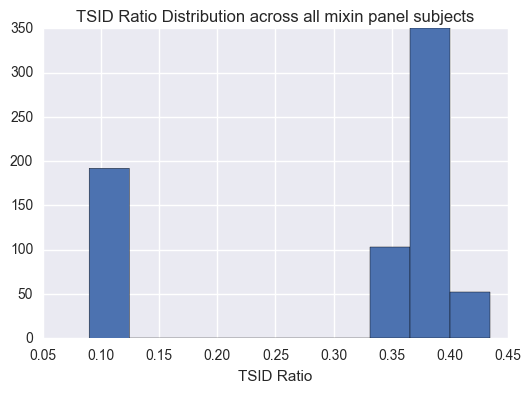

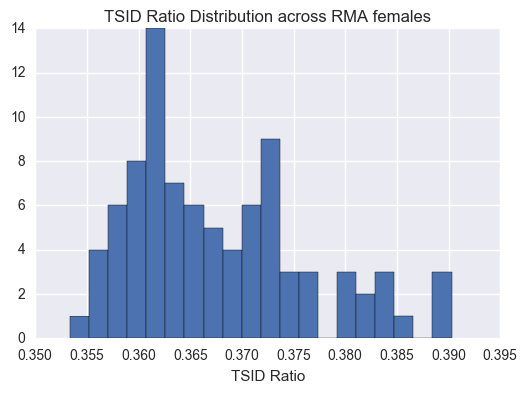

In [6]:
plt.figure()
plt.hist(coverage_df_M1.tsid_ratio)
plt.xlabel('TSID Ratio'), plt.title('TSID Ratio Distribution across all mixin panel subjects')

plt.figure()
plt.hist(coverage_df_RMA.tsid_ratio, bins=20)
plt.xlabel('TSID Ratio'), plt.title('TSID Ratio Distribution across RMA females')

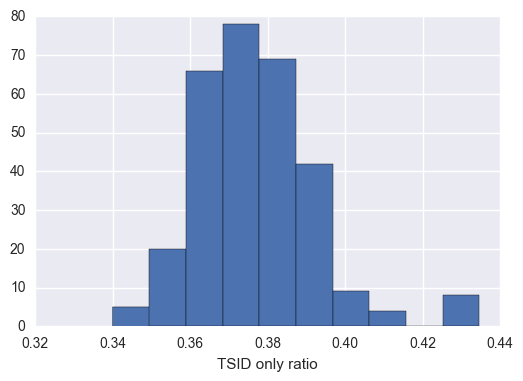

In [7]:
coverage_df_control = coverage_df_f[(coverage_df_f.tsid_ratio < 0.45) & (coverage_df_f.tsid_ratio > 0.3)]
plt.figure()
plt.hist(coverage_df_control.tsid_ratio)
plt.xlabel('TSID only ratio')

There appears to be a subset of M1 subjects who were run on a very different version of the panel (with a significantly different TSID_only ratio -- around 0.1 instead of 0.38)

(array([  6.,   2.,   7.,   8.,  11.,  18.,  12.,  10.,   4.,   4.]),
 array([ 0.01182062,  0.01257072,  0.01332082,  0.01407093,  0.01482103,
         0.01557113,  0.01632124,  0.01707134,  0.01782144,  0.01857154,
         0.01932165]),
 <a list of 10 Patch objects>)

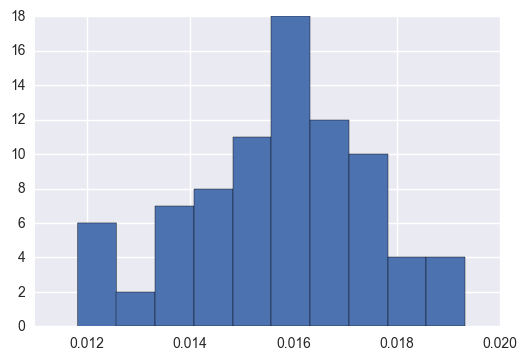

In [184]:
control = coverage_df_control.drop(['tsid_ratio', 'TSID_only', 'TSO_only'], axis=1)
control_grouped = control.groupby('subject').sum()
control_norm = control_grouped.div(control_grouped.sum(axis=1), axis=0)
control_norm.head()
plt.figure()
plt.hist(control_norm.Ex15)

## Gibbs Sampling -- new prior multinomial logistic prior will be added here and below


The full gene product of DMD consists of 78 exons, each with its own copy number in each subject ($\mathbf{C} = \{c_1, c_2, ..., c_{78}\}$), where $c_i \in{1,2,3...}$ For this simple model, assume that the $c_i$ are distributed discrete uniformly with support $ \{1,2,3\}$. 

This model also includes "intensity" values across the exons $\mathbf{X}= \{x_1, x_2,..., x_{78}\}$, and we let $$\mathbf{P} = \dfrac{\mathbf{C}\mathbf{X}}{\sum_i c_ix_i} = \{p_1, p_2, ..., p_{78}\}$$ 
From here we let $k = 78$ to represent the model more generally.

Thus our generative model assumes that the reads for every sequencing run (whether simulated or real) are distributed according to a multinomial distribution with probability vector $\mathbf{P}$. Furthermore, we assume that $\mathbf{X}$ are drawn from a Dirichlet distribution with known vector of priors $\mathbf{\gamma}$. If we let $\mathbf{Y}$ represent the data from a single subject (where $y_i$ represents the number of reads mapped to exon $i$), we can write the joint distribution as:

$$ 
\begin{align}
\Pr(\mathbf{C}, \mathbf{Y}, \mathbf{X}; \mathbf{\gamma}) \;\; &\propto \;\;\prod_{i=1}^k p_i^{y_i} \prod_{i=1}^k x_i^{\gamma_i - 1} \\
&\propto \;\;\prod_{i=1}^k \left(\dfrac{c_ix_i}{\sum c_ix_i}\right)^{y_i} \prod_{i=1}^k x_i^{\gamma_i - 1} \\
&\propto \;\;\left(\dfrac{1}{\sum c_ix_i}\right)^\mathbb{T} \prod_{i=1}^k \left(c_ix_i\right)^{y_i} \prod_{i=1}^k x_i^{\gamma_i - 1} \\
&\propto \;\;\left(\dfrac{1}{\sum c_ix_i}\right)^\mathbb{T} \prod_{i=1}^k c_i^{y_i} x_i^{y_i + \gamma_i - 1}
\end{align}
$$
Note that we have left out the normalization constants for the multinomial and Dirichlet distributions and $\mathbb{T} = \sum_i y_i$ represents the total number of reads in $\mathbf{Y}$. Thus the complete joint distribution would be 
$$ \Pr(\mathbf{C}, \mathbf{Y}, \mathbf{X}; \mathbf{\gamma}) \;\; = \;\; \dfrac{\mathbb{T}!}{y_1!... y_k!} \dfrac{\Gamma (\sum \gamma_i)}{\prod \Gamma (\gamma_i)}\left(\dfrac{1}{\sum c_ix_i}\right)^\mathbb{T} \prod_{i=1}^k c_i^{y_i} x_i^{y_i + \gamma_i - 1} $$

**Running the Gibbs Sampler**

Initialize the intensities $\mathbf{X}$ from $\text{Dirichlet}(\gamma)$ where the desired coverage ratios have been appropriately scaled to increase the bias of the prior. Initialize $c_i$ values based on basic prior distribution. If testing (without subject data), we can also generate fake subject data. 

At each iteration $t$, sample $c_i^t$ from the posterior distribution
$$f_{C^t|Y, C_{-i}^t}(c) = \dfrac{\left(\dfrac{1}{\sum c_jx_j}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_j} x_j^{y_j + \gamma_j - 1} \vert c_i = c} {\sum_c \left(\dfrac{1}{\sum c_jx_j}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_j} x_j^{y_j + \gamma_j - 1} \vert c_i = c}$$ 
where $$ \mathbf{C_{-i}}^t = \{ c_1^t,...c_{i-1}^t, c_{i+1}^{t-1}, ... c_{78}^{t-1} \}$$



Normally this expression would include the prior distribution over $c$ but it easily cancels out as the uniform. (This expression also does not include the multinomial or dirichlet constants). In fact, we can also cancel some of the $x_j$ terms:
$$f_{C^t|Y, C_{-i}^t}(c) = \dfrac{\left(\dfrac{1}{\sum c_jx_j}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_i} \vert c_i = c} {\sum_c \left(\dfrac{1}{\sum c_jx_j}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_j} \vert c_i = c}$$
At the end of each iteration, we also need to resample $\mathbf{X}$. Normally the Dirichlet is the conjugate prior of the multinomial, but in our case we have the more complex posterior:

$$ \begin{align}
\Pr(\mathbf{X} | \mathbf{Y}, \mathbf{C}; \gamma) &\propto \Pr(\mathbf{X}|\gamma) \Pr(\mathbf{Y}, \mathbf{C} | \mathbf{X}) \\
&\propto \prod x_i^{\gamma_i -1} \prod \left(\dfrac{c_i x_i}{\sum c_ix_i} \right)^{y_i} \\
&\propto \prod \dfrac{c_i^{y_i}x_i^{y_i + \gamma_i -1}}{\left(\sum c_ix_i \right)^{y_i}}
\end{align} $$

$$ \prod_{i=1}^k \dfrac{x_i^{y_i + \gamma_i -1}}{\left(\sum c_ix_i \right)^{y_i}} $$

**Implementation considerations**: $\prod_{j=1}^k c_j^{y_i} x_j^{y_j + \gamma_j - 1}$ can cause under/overflow in Python (or washout of values too close to 0)

**Solution**: Convert to log space and divide by the maximal likelihood to normalize (and keep values from shrinking too close to 0):

In other words, calculate the value below for each $c_i = c$ and then divide by their sum to normalize.
$$ \exp\left(-\mathbb{T} \log(\sum c_jx_j) +  \sum (y_j \log c_j + (y_j + \gamma_j -1)\log x_j) - \max_c \left( -\mathbb{T} \log(\sum c_jx_j) +  \sum (y_j \log c_j + (y_j + \gamma_j -1)\log x_j) \right) \right)$$ 

Store the $C^t$ values only for iterations $t=1000... 10,000$. This allows for a burn-in period of 1000 iterations during which the sampling distributions are likely to be least accurate. To reduce auto-correlation, only include every hundredth sampling in final analysis as well. For each exon $i$, count the proportions of samples falling into each possible copy number across the relevant subset of iterations. 


### Next Steps
* Incorporate more complex and representative prior for the copy number distribution (in particular, there should be higher prior probability for 2 copies of exon)
* Determine more accurate estimate of burn-in period (strange log-likelihood behavior, should converge as iterations increase)
* Account for increased likelihood of copy number correlation between neighboring exons
* Consider modifying prior for two exon deletion hotspots (around 45-50 and 18-20)
* **Incorporate step for correcting for mixin-based discrepancies**


In [619]:
X_probs 

array([ 0.04215466,  0.00503887,  0.01219685,  0.01949855,  0.01014229,
        0.01530697,  0.02292741,  0.01966598,  0.00658655,  0.01536095,
        0.01302953,  0.00913421,  0.0080407 ,  0.00969923,  0.01683406,
        0.00958058,  0.01332116,  0.0064703 ,  0.01296143,  0.02752234,
        0.01172826,  0.01629112,  0.01099417,  0.00869235,  0.02590953,
        0.00953366,  0.01891899,  0.00953329,  0.01449503,  0.00728083,
        0.01279229,  0.00914364,  0.01849212,  0.00803307,  0.01080465,
        0.01037349,  0.01150525,  0.00775733,  0.01022832,  0.01134996,
        0.01079948,  0.00765549,  0.0149941 ,  0.01410612,  0.02586731,
        0.00834665,  0.02153014,  0.01143097,  0.02477873,  0.00813239,
        0.0091945 ,  0.00700924,  0.01860981,  0.00758001,  0.02073513,
        0.00858007,  0.00671624,  0.00783585,  0.01204692,  0.01874403,
        0.01044444,  0.01646457,  0.00729369,  0.01199439,  0.01896777,
        0.01145101,  0.01696939,  0.00884788,  0.01135852,  0.00

In [804]:
def generate_gibbs_df(cnv_support, X_priors, data=None, cnv=None, scale=7e4, sim_reads=3e4, iterations=10000, burn_in=1000,
                      df_wanted=True, exon_labels=None):
    '''Performs Gibbs sampling given a support vector for CNVs, an intensity vector and subject data (optional)'''
    # initialization of cnv counts and intensity vector
    if cnv is None:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(X_priors)) 
    print cnv
    # we're using a scaling factor for the X_priors (small ratios give too much variability in the dirichlet)
    X_vect = np.random.dirichlet(X_priors * scale)
    # consider returning this vector along with initial cnv vector
    normed_probs_first = np.multiply(cnv, X_vect) / np.sum(np.multiply(cnv, X_vect))
    # for testing only
    if data is None:
        data = np.random.multinomial(sim_reads, normed_probs_first)
    
    gibbs_cnv_data = np.zeros((len(X_priors), iterations))
    gibbs_X = np.zeros((iterations, len(X_priors)))
    likelihoods = np.zeros(iterations)
    
    # begin iterations
    for i in range(iterations):
        if iterations > 20 and (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        # sample all cnv values
        for exon in range(len(X_priors)):
            test = np.zeros(len(cnv_support))
            old = cnv[exon]
            for value in cnv_support:
                cnv[exon] = value
                # get new normed probabilities given test value and priors for exon intensities
                log_probs_norm = np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, X_vect)))
                log_likelihood = (log_probs_norm + 
                                 np.sum(np.multiply(np.log(cnv), data)))
                test[value - 1] = log_likelihood
            test = test - np.max(test)
            sample_probs = np.exp(test)
            sample_probs = sample_probs / np.sum(sample_probs)
            new_cnv = np.random.choice(cnv_support, p = sample_probs)
            cnv[exon] = new_cnv
            gibbs_cnv_data[exon, i] = new_cnv
        # sample new X_vect after updating with data -- this is not the real posterior
        X_vect = np.random.dirichlet(X_priors * scale + data)
        gibbs_X[i] = X_vect
        
        log_probs_norm_fin = np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, X_vect)))
        likelihoods[i] = (log_probs_norm + 
                          np.sum(np.multiply(np.log(cnv), data) + 
                                 np.multiply((data + (X_priors * scale) - 1), np.log(X_vect))))
    
    # get proportions using burn-in of 1000 iterations 
    gibbs_data_results = np.zeros((len(X_priors), len(cnv_support)))
    for index in range(len(X_priors)):
        # exclude samples before burn in and then take only every 100th sample to reduce autocorrelation
        gibbs_slice = gibbs_cnv_data[index][burn_in:][::100]
        gibbs_data_results[index] = np.bincount(gibbs_slice.astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    gibbs_data_results = gibbs_data_results / float(len(gibbs_slice))
    
    # return df for easier visualization
    if df_wanted:
        gibbs_df = pd.DataFrame(gibbs_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support])
        gibbs_df['Exon'] = exon_labels
        return gibbs_cnv_data, gibbs_X, gibbs_data_results, likelihoods, gibbs_df
    
    return gibbs_cnv_data, gibbs_X, gibbs_data_results, likelihoods

## Rerunning Gibbs Sampling with varying intensity vectors
The gibbs sampling done here will be performed with intensity vectors based on subsets of subjects with similar TSID_only ratios to the individual test subject. 

In [391]:
# use RMA samples for initial intensity vector -- note that all RMA individuals used the M1 mixin panel
# this is only the females in RMA
print coverage_df_RMA.sequencer.unique()
rma_ex = coverage_df_RMA[gibbs_columns]
RMA_norm = reshape_df(rma_ex, include_stats=True)
RMA_norm.head()
X_probs = np.array(RMA_norm.Mean)
print len(X_probs)
X_probs
RMA_norm.head()

['M1']
78


subject,Exon,FRMR-0070-444H,FRMR-0081-1987,FRMR-0085-579V,FRMR-00AG-860T,FRMR-00AW-8645,FRMR-00BB-772T,FRMR-00CS-821F,FRMR-00DM-853C,FRMR-00GC-803L,...,FRMR-00MS-704S,FRMR-00NC-7632,FRMR-00SA-876L,FRMR-00SB-851W,FRMR-00SC-714V,FRMR-00SD-679G,FRMR-00ST-841F,FRMR-00TS-8464,Mean,SD
0,Ex1,0.039897,0.043291,0.038417,0.043620,0.039123,0.040485,0.039708,0.040878,0.045125,...,0.043579,0.046018,0.038485,0.039989,0.043555,0.037319,0.045118,0.040692,0.042155,0.002726
1,Ex2,0.004678,0.005073,0.005041,0.005331,0.005397,0.004894,0.004709,0.004108,0.005038,...,0.005191,0.004444,0.004449,0.005499,0.004628,0.006340,0.005937,0.005740,0.005039,0.000552
2,Ex3,0.012082,0.011451,0.011480,0.011187,0.011614,0.012285,0.012389,0.012783,0.012536,...,0.012038,0.012118,0.012041,0.012671,0.011442,0.010723,0.014282,0.013281,0.012197,0.000780
3,Ex4,0.018110,0.017262,0.017888,0.022636,0.017079,0.015429,0.021727,0.019059,0.020194,...,0.021530,0.021213,0.019180,0.017283,0.019932,0.015830,0.021847,0.021208,0.019499,0.002122
4,Ex5,0.009605,0.010441,0.010781,0.012763,0.009086,0.009238,0.011827,0.011468,0.009755,...,0.009813,0.008397,0.010155,0.009478,0.009228,0.010383,0.010177,0.010012,0.010142,0.000944


In [303]:
# more refined subset based on tsid_ratios
gibbs_columns = ['subject'] + [column for column in rma_subset.columns if 'Ex' in column]

rma38 = rma_subset[gibbs_columns]
rma38_norm = reshape_df(rma38, include_stats=True)
X_probs38 = np.array(rma38_norm.Mean)
rma38_norm.head()

subject,Exon,FRMR-00AW-8645,FRMR-00GC-803L,FRMR-00JD-7770,FRMR-00JM-865U,FRMR-00MM-839J,FRMR-00MS-704S,FRMR-00NC-7632,Mean,SD
0,Ex1,0.039123,0.045125,0.045128,0.044675,0.044764,0.043579,0.046018,0.044059,0.002124
1,Ex2,0.005397,0.005038,0.005161,0.005173,0.004583,0.005191,0.004444,0.004998,0.000324
2,Ex3,0.011614,0.012536,0.012873,0.012155,0.011836,0.012038,0.012118,0.012167,0.000391
3,Ex4,0.017079,0.020194,0.020702,0.021155,0.020224,0.021530,0.021213,0.020300,0.001395
4,Ex5,0.009086,0.009755,0.010380,0.010345,0.010234,0.009813,0.008397,0.009716,0.000682


In [741]:
test_scale = 3e4
test_mse = []
# print scipy.stats.dirichlet.mean(test_scale * np.array(rma38_norm.Mean))
print np.power(np.array(rma38_norm.SD), 2)
print scipy.stats.dirichlet.var(1.7e4 * np.array(rma38_norm.Mean))
# for i in range(len(rma38_norm.columns) - 3):
#     test_pdf.append(scipy.stats.dirichlet.pdf(rma38_norm[rma38_norm.columns[i+1]], test_scale * rma38_norm.Mean))
# test_pdf
for i in np.linspace(0.1, 10, 100):
    test_scale = i * 1e4
    sample_var = np.power(np.array(rma38_norm.SD)[1:], 2)
    dir_var = scipy.stats.dirichlet.var(test_scale * np.array(rma38_norm.Mean)[1:])
    mse = np.mean(np.square(sample_var - dir_var))
    test_mse.append(mse)

[  4.51288618e-06   1.04841442e-07   1.52665496e-07   1.94712220e-06
   4.64597497e-07   2.64857077e-06   2.76699878e-06   5.53924561e-07
   2.39413775e-07   6.70546053e-07   4.36535102e-07   3.14621056e-07
   6.33629856e-07   6.68560886e-08   1.07180846e-06   3.07127719e-07
   1.09843232e-06   1.21862016e-07   1.21106937e-06   1.66611969e-06
   7.98581676e-07   6.21120498e-07   5.67704903e-07   6.44884301e-07
   6.15230736e-07   8.97684875e-07   2.34245009e-06   2.31578253e-07
   7.98362370e-07   4.22333112e-07   1.38605569e-07   5.25180328e-07
   1.35902452e-06   1.02318248e-06   6.62485467e-07   1.12283187e-06
   1.56995061e-06   8.49927042e-07   2.27578872e-07   5.86724035e-07
   2.43451361e-07   7.89526673e-07   1.03612278e-06   1.68796636e-06
   2.06001009e-06   5.90821403e-07   1.20270314e-06   5.93455486e-07
   2.56890064e-06   4.11123915e-07   9.05985572e-07   7.84081775e-07
   4.27119593e-07   4.21728937e-07   6.08296535e-07   2.03837445e-07
   1.15396492e-07   1.93552139e-07

In [740]:
np.linspace(0.1, 10, 100)[np.argmin(test_mse)]

1.7000000000000002

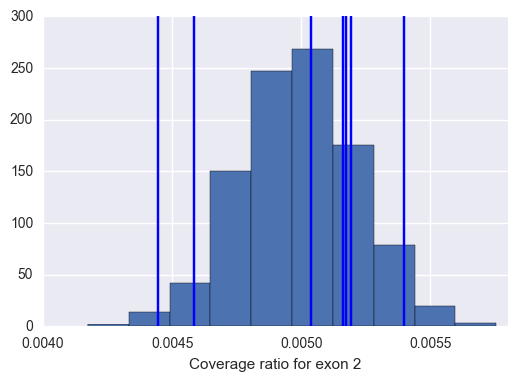

In [801]:
test_scale = 9e4
test_many = np.random.dirichlet(test_scale * np.array(rma38_norm.Mean), 1000)
plt.figure()
plt.hist(test_many[:, 1])
plt.xlabel('Coverage ratio for exon 2')
for cover in rma38_norm.iloc[1][1:-2]:
    plt.axvline(x=cover)

In [346]:
# subset for subject J0F1 
m1_43 = m1_subset43[gibbs_columns]
m1_43_norm = reshape_df(m1_43, include_stats=True)
X_probs43 = np.array(m1_43_norm.Mean)
m1_43_norm.head()

subject,Exon,FGPC-1PR1-SON4,FGPC-INSR-YI4C,Mean,SD
0,Ex1,0.050868,0.050952,0.050910,0.000042
1,Ex2,0.006013,0.006189,0.006101,0.000088
2,Ex3,0.011639,0.011508,0.011573,0.000066
3,Ex4,0.018458,0.020505,0.019482,0.001024
4,Ex5,0.010982,0.012079,0.011531,0.000549


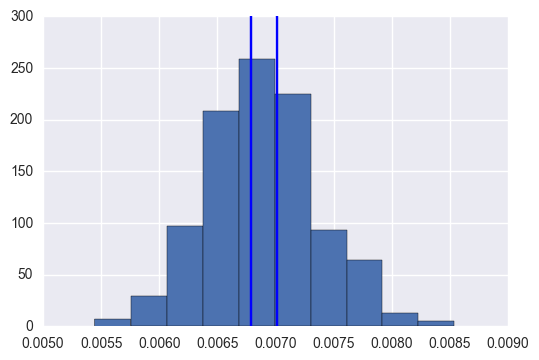

In [719]:
test_scale = 3e4
test_many = np.random.dirichlet(test_scale * np.array(m1_43_norm.Mean), 1000)
plt.figure()
plt.hist(test_many[:, 12])
for cover in m1_43_norm.iloc[12][1:-2]:
    plt.axvline(x=cover)

In [680]:
# generating coverage counts for superset of exons
reload(cov)
test_subjects_num = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, 
                                                                tsid_exon_labels, bam_dir='../bams/test_subjects')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp
Finished parsing all 6 subjects
165124 reads were skipped due to outside_of_exon
4612 reads were skipped due to MAPQ below 60


In [286]:
%%time
# generating coverage counts for only primary transcript exons, note that this will run slowly if coverageMatrix()
# code has not been updated 
reload(cov)
test_subjects_prim = cov.coverageMatrix().create_coverage_matrix(DMD_exons_merged, 
                                                                 exon_labels, bam_dir='../bams/test_subjects')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp
Finished parsing all 6 subjects
187493 reads were skipped due to outside_of_exon
4492 reads were skipped due to MAPQ below 60


CPU times: user 5.51 s, sys: 102 ms, total: 5.61 s
Wall time: 5.69 s


In [287]:
# test_subjects = pd.DataFrame(coverage_matrix[1:], columns=coverage_matrix[0])
# test_subjects_num = test_subjects.apply(lambda x: pd.to_numeric(x, errors='ignore'))
test_subjects_prim.date_modified = pd.to_datetime(test_subjects_prim.date_modified, unit='s')
test_subjects_prim['date'] = test_subjects_prim.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
# test_subjects_num.drop(['is_rerun'], axis=1, inplace=True)
test_subjects_sub = test_subjects_prim[gibbs_columns]
test_subjects_rel = test_subjects_num[test_subjects_num.columns[:12]]
# test_subjects_rel['tsid_ratio'] = test_subjects_rel.TSID_only / (test_subjects_rel.TSID_only + test_subjects_rel.TSO_only)
print test_subjects_num.subject.unique()
print test_subjects_num.date.unique()
test_subjects_rel.head()

['FGPC-0000-444F' 'FGPC-0000-444F_dup' 'FGPC-4ZPF-J0F1'
 'FGPC-4ZPF-J0F1_del' 'FPWB-0000-822R' 'FPWB-0000-822R_del']
[datetime.date(2016, 6, 24) datetime.date(2017, 2, 17)
 datetime.date(2016, 6, 25)]


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,TSID_only,TSO_only
0,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L004,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L004,0.7.13-r1126,2016-06-24 22:20:44,55974,92663
1,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L002,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L002,0.7.13-r1126,2016-06-24 22:20:44,59880,97132
2,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L003,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L003,0.7.13-r1126,2016-06-24 22:20:44,57005,92448
3,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L001,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L001,0.7.13-r1126,2016-06-24 22:20:44,59975,97833
4,FGPC-0000-444F_1-M1-1_H5FGFAFXX-L004,FGPC-0000-444F_dup,FGPC-0000-444F_dup_1,FGPC-0000-444F_dup_1-M1-1,F,M1,H5FGFAFXX,L004,0.7.13-r1126,2017-02-17 17:23:06,55974,92663


In [300]:
subject_norm, subject_counts = reshape_df(test_subjects_sub, df_counts_wanted=True)
subject_counts.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
subject,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,552
FGPC-0000-444F_dup,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,552
FGPC-4ZPF-J0F1,1649,118,385,558,378,554,720,603,257,455,...,347,178,442,363,466,265,237,391,179,446
FGPC-4ZPF-J0F1_del,1649,118,385,558,378,554,720,603,257,455,...,347,178,442,363,466,265,237,391,179,446
FPWB-0000-822R,2986,258,761,1123,617,1150,1462,1247,451,960,...,799,358,758,562,990,469,518,698,308,696


In [720]:
subject_norm.head(15)

subject,Exon,FGPC-0000-444F,FGPC-0000-444F_dup,FGPC-4ZPF-J0F1,FGPC-4ZPF-J0F1_del,FPWB-0000-822R,FPWB-0000-822R_del
0,Ex1,0.040142,0.040015,0.048768,0.049482,0.045403,0.046511
1,Ex2,0.005421,0.005404,0.003490,0.003541,0.003923,0.004019
2,Ex3,0.011037,0.011001,0.011386,0.011553,0.011571,0.011854
3,Ex4,0.016723,0.016670,0.016503,0.016744,0.017076,0.017492
4,Ex5,0.010470,0.010436,0.011179,0.011343,0.009382,0.009611
5,Ex6,0.012649,0.012608,0.016384,0.016624,0.017486,0.017913
6,Ex7,0.023756,0.023680,0.021294,0.021605,0.022230,0.022773
7,Ex8,0.018849,0.018789,0.017833,0.018095,0.018961,0.019424
8,Ex9,0.007281,0.007258,0.007601,0.007712,0.006858,0.007025
9,Ex10,0.012666,0.012626,0.013456,0.013653,0.014597,0.014953


In [301]:
data_dict = {subject.split('-')[-1]: np.array(subject_counts.loc[subject]) for subject in test_subjects_sub.subject.unique()}
data_dict['444F']

array([2266,  306,  623,  944,  591,  714, 1341, 1064,  411,  715,  677,
        519,  443,  549,  702,  448,  784,  433,  926, 1608,  664,  933,
        629,  541, 1369,  558, 1061,  528,  821,  500,  684,  525,  947,
        485,  638,  645,  667,  497,  642,  689,  641,  480,  709,  901,
       1494,  468, 1202,  630, 1307,  454,  546,  414,  961,  415, 1196,
        447,  414,  503,  659, 1068,  588,  942,  365,  712, 1028,  713,
       1048,  506,  659,  272,  729,  631,  847,  523,  424,  622,  292,
        552])

In [805]:
%%time
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822R, gibbsX_822R, gibbs_data_results_822R, logliks_822R, gibbs_df_822R = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['822R_del'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 1 1 1 2 3 2 2 1 2 3 3 1 3 1 3 1 1 1 1 3 2 2 1 2 3 2 3 3 3 1 1 3 2 1 1 1
 1 1 1 2 1 3 3 1 1 2 3 2 2 1 2 3 1 3 3 3 1 1 1 3 2 1 3 2 2 1 1 1 1 1 2 1 1
 1 1 2 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
CPU times: user 58.1 s, sys: 480 ms, total: 58.6 s
Wall time: 59.5 s


In [806]:
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822Rc, gibbsX_822Rc, gibbs_data_results_822Rc, logliks_822Rc, gibbs_df_822Rc = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['822R'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 1 3 1 1 2 3 2 1 1 1 3 1 2 1 2 3 3 3 1 2 2 2 2 1 1 1 3 3 2 1 2 2 2 2 1 2
 2 1 1 3 3 1 3 1 1 2 1 1 1 1 3 1 3 2 1 3 2 3 3 2 2 3 1 3 2 2 1 3 3 3 2 3 3
 1 3 2 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [477]:
# reference: http://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html
def create_stacked_bars(df, title): 
    f, ax = plt.subplots(1, figsize=(15,7))
    bar_width = 1

    bar_l = [i for i in range(len(df['copy_1']))] 
    tick_pos = [i + bar_width for i in bar_l] 

    # loop through these later
    # Create a bar chart in position bar_1
    ax.bar(bar_l, df.copy_1, label='1 Copy', alpha=0.9, color='#019600', width=bar_width, edgecolor='white')

    ax.bar(bar_l, df.copy_2, bottom=df.copy_1, label='2 Copy', alpha=0.9, color='#3C5F5A', width=bar_width,
           edgecolor='white')

    ax.bar(bar_l, df.copy_3, bottom=[i+j for i,j in zip(df.copy_1, df.copy_2)], label='3 Copy',
           alpha=0.9, color='#219AD8', width=bar_width, edgecolor='white')

    # getting just the number designation for each exon group as its label
    plt.xticks(tick_pos, df['Exon'].str.split('x').str[-1])
    ax.set_ylabel("Probabilities")
    ax.set_xlabel("Exons")

    plt.xlim([min(tick_pos)-2*bar_width, max(tick_pos)+bar_width])
    plt.ylim(-0.1, 1.1)

    plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=3)
    plt.title(title)
    plt.show()

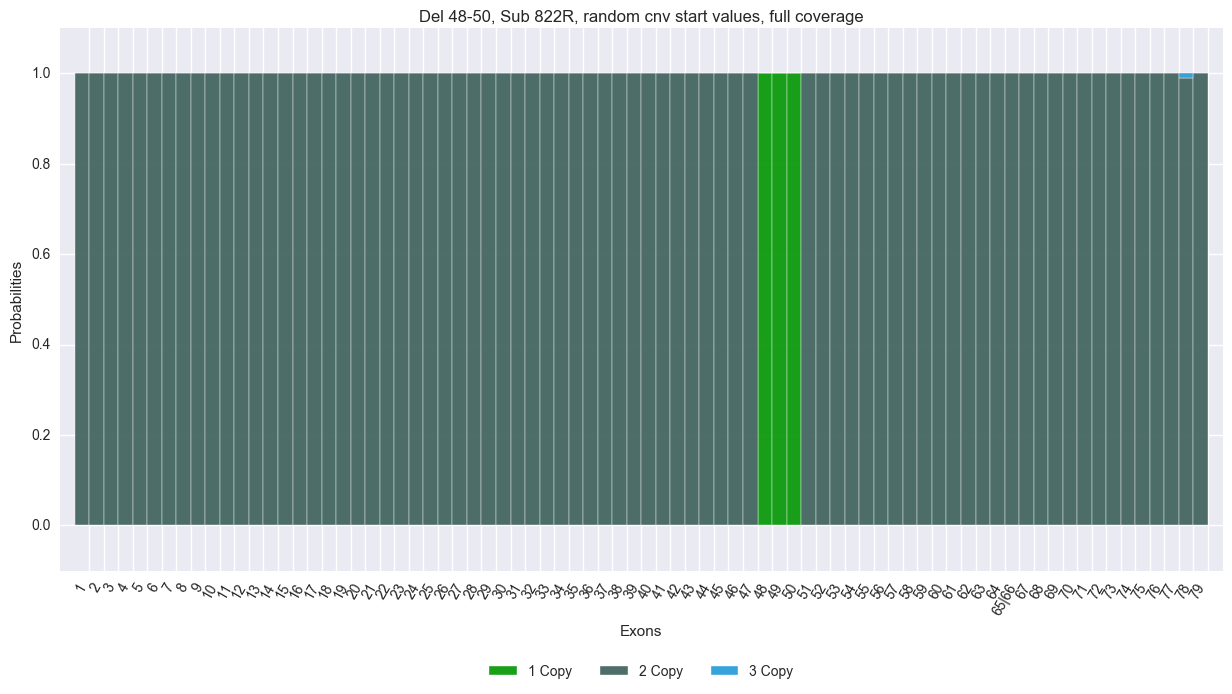

In [807]:
create_stacked_bars(gibbs_df_822R, 'Del 48-50, Sub 822R, random cnv start values, full coverage')

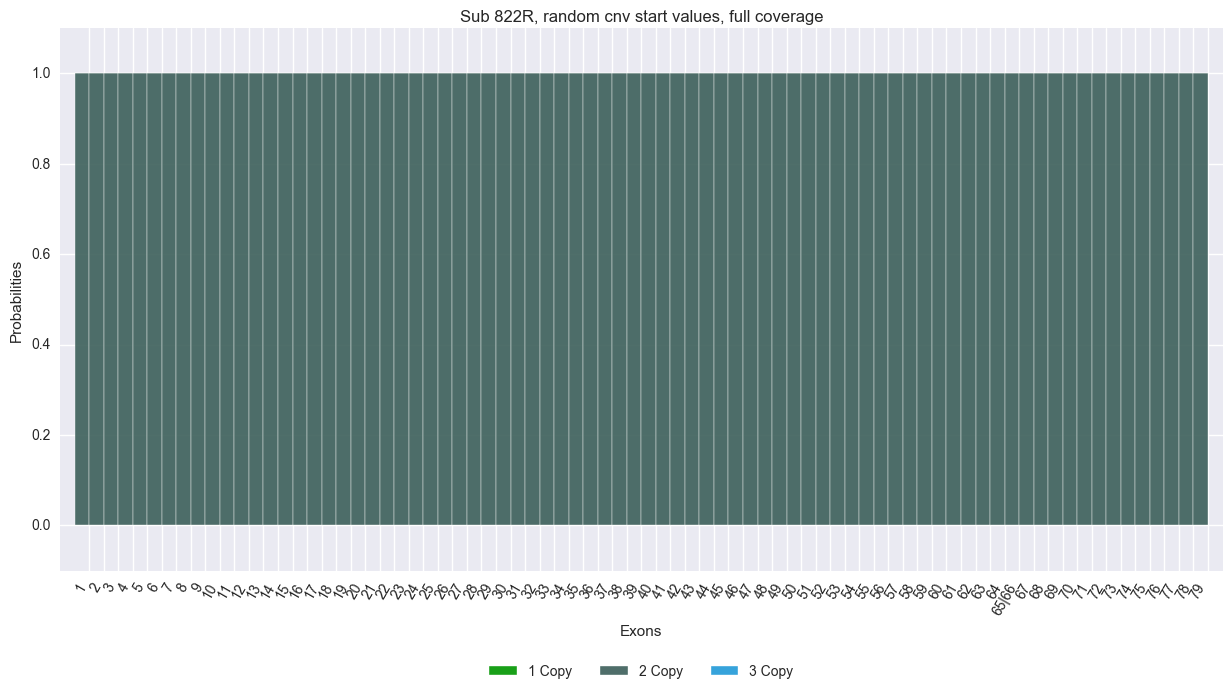

In [808]:
create_stacked_bars(gibbs_df_822Rc, 'Sub 822R, random cnv start values, full coverage')

(<matplotlib.text.Text at 0x116a6af10>, <matplotlib.text.Text at 0x11100c910>)

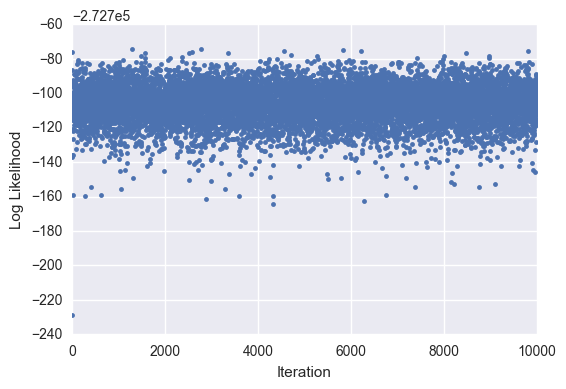

In [651]:
plt.figure()
plt.plot(range(len(logliks_822R2)), logliks_822R2, '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')

In [667]:
# this subject's mutation was simulated with a 0.65 mult factor (instead of 0.5) so I'm correcting for it here
data_dict['J0F1_del'][15:19] = (data_dict['J0F1_del'][15:19]) * (0.5 / 0.65)

In [813]:
%%time
cnv_support = [1,2,3]
gibbs_data_J0F1, gibbsX_J0F1, gibbs_data_results_J0F1, logliks_J0F1, gibbs_df_J0F1 = generate_gibbs_df(cnv_support, 
                                                                        X_probs43, data=data_dict['J0F1_del'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 1 3 1 3 1 1 1 1 3 1 3 1 3 1 3 1 3 2 3 1 3 2 2 2 1 1 2 3 3 1 3 2 3 2 3 1
 3 1 1 3 1 2 1 2 2 3 1 3 2 1 1 3 2 1 2 2 1 3 3 1 2 1 1 1 1 2 2 2 1 1 2 2 1
 3 3 3 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
CPU times: user 56.7 s, sys: 324 ms, total: 57 s
Wall time: 57.6 s


In [814]:
cnv_support = [1,2,3]
gibbs_data_J0F1c, gibbsX_J0F1c, gibbs_data_results_J0F1c, logliks_J0F1c, gibbs_df_J0F1c = generate_gibbs_df(cnv_support, 
                                                                        X_probs43, data=data_dict['J0F1'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 3 3 3 3 1 1 2 3 3 3 1 2 1 3 3 1 1 3 3 3 2 3 2 3 1 3 3 2 1 3 3 1 3 1 1 1
 1 2 1 2 1 1 1 3 2 2 3 2 1 2 2 3 3 1 1 3 1 2 3 3 1 1 2 1 3 1 1 1 2 2 2 2 3
 2 2 1 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


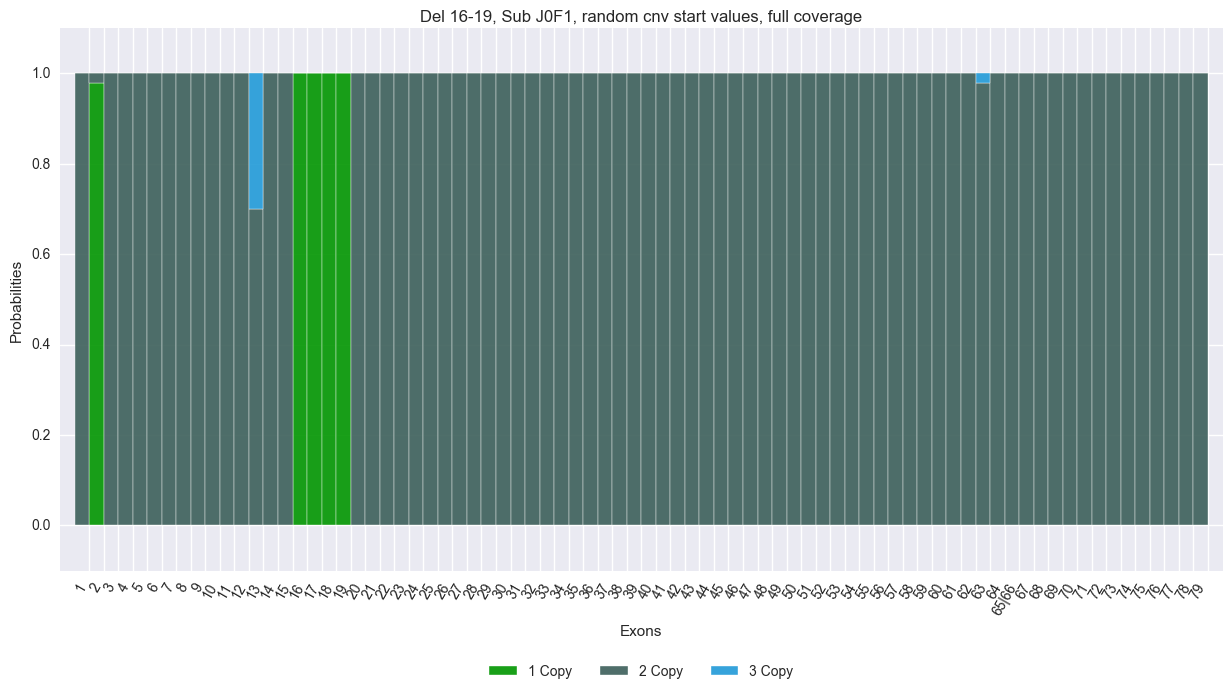

In [815]:
create_stacked_bars(gibbs_df_J0F1, 'Del 16-19, Sub J0F1, random cnv start values, full coverage')

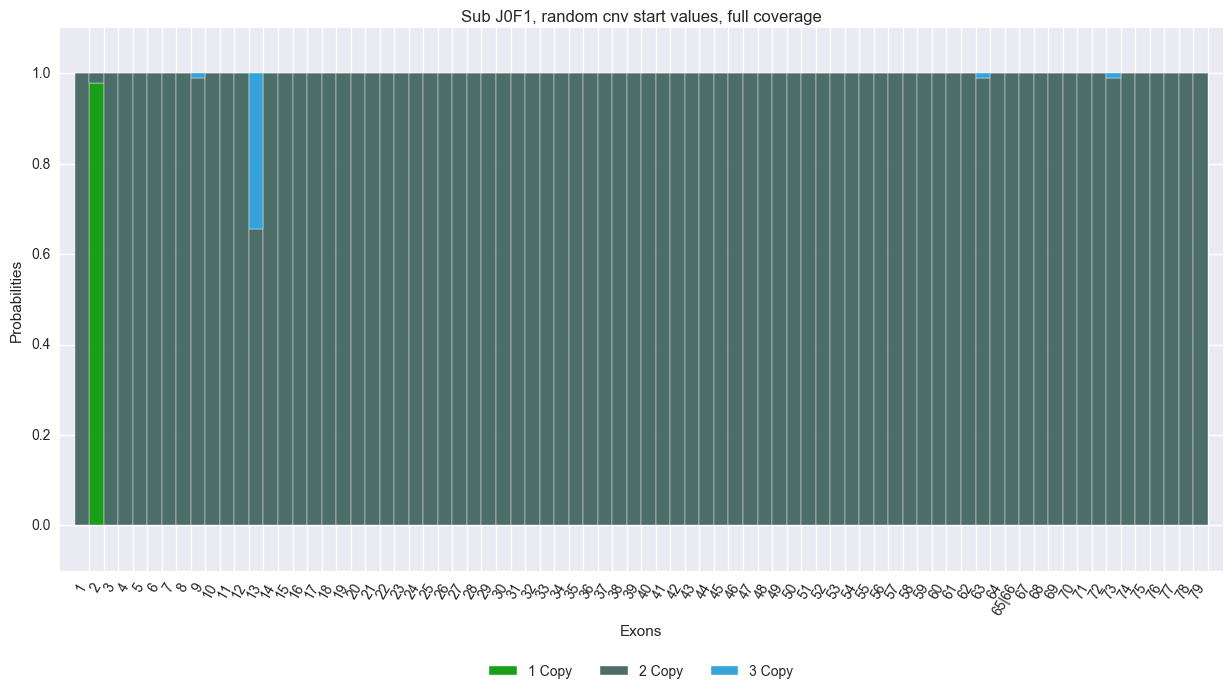

In [816]:
create_stacked_bars(gibbs_df_J0F1c, 'Sub J0F1, random cnv start values, full coverage')

In [786]:
cnv_support = [1,2,3]
gibbs_data_444F, gibbsX_444F, gibbs_data_results_444F, logliks_444F, gibbs_df_444F = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['444F_dup'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[1 1 1 1 3 3 3 3 3 3 1 2 2 2 1 3 2 2 2 2 2 1 3 3 3 2 1 3 3 1 3 2 2 1 1 1 1
 3 2 3 3 3 1 3 3 3 2 1 3 1 1 3 1 2 1 1 2 1 1 3 1 3 3 3 2 2 3 3 1 2 2 2 2 1
 3 2 2 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


In [787]:
cnv_support = [1,2,3]
gibbs_data_444Fc, gibbsX_444Fc, gibbs_data_results_444Fc, logliks_444Fc, gibbs_df_444Fc = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['444F'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[2 3 3 3 3 2 1 3 2 1 1 3 2 2 1 2 3 3 3 3 3 1 1 1 3 1 2 1 2 3 3 3 2 1 1 2 2
 2 1 1 2 1 1 2 1 3 1 1 2 1 3 1 1 2 2 1 3 1 1 2 3 2 3 2 1 2 1 3 1 3 2 3 2 3
 1 1 1 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


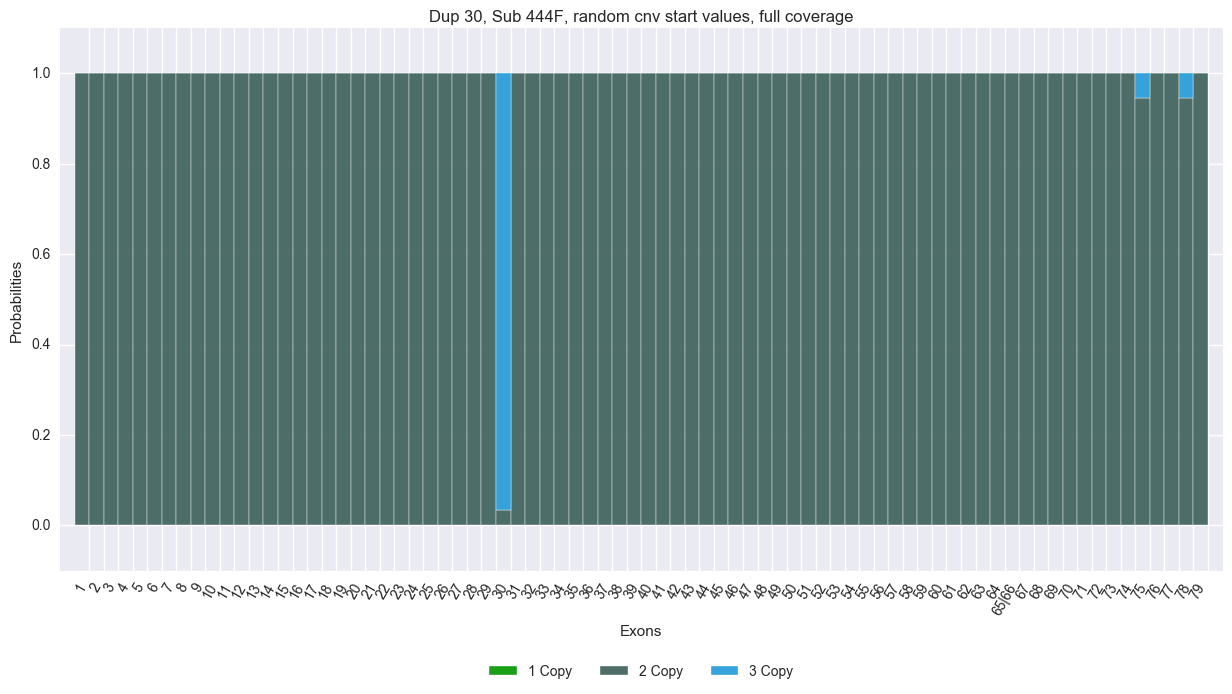

In [788]:
create_stacked_bars(gibbs_df_444F, 'Dup 30, Sub 444F, random cnv start values, full coverage')

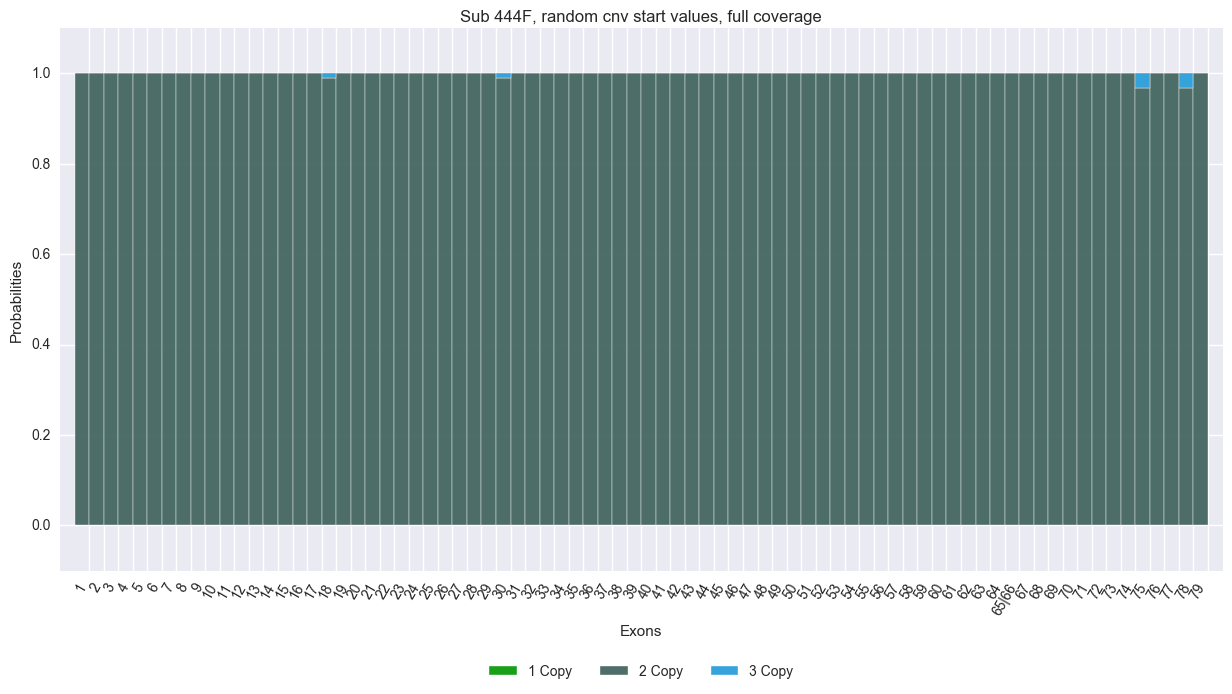

In [789]:
create_stacked_bars(gibbs_df_444Fc, 'Sub 444F, random cnv start values, full coverage')

This subject (and any simulated mutations based on her) will probably be excluded from future tests because her bams are actually merged files from the results of sequencing with at least two different mixin panels. This might explain the abnormal exon coverage ratios for at least some exons.

In [273]:
estimate_prop_full = (test_norm_rel.TSID_only - regression_full.params[0]) / regression_full.params[1]
estimate_prop_full

subject
FGPC-0000-444F        0.349709
FGPC-0000-444F_dup    0.349709
FGPC-4ZPF-J0F1        0.404720
FGPC-4ZPF-J0F1_del    0.404720
FPWB-0000-822R        0.351999
FPWB-0000-822R_del    0.351999
Name: TSID_only, dtype: float64